# Confidence Finder

In [9]:
from fast_poibin import PoiBin
import numpy as np
import matplotlib.pyplot as plt
from intersect import intersection

import sinter 
import pandas as pd

import scipy.stats as st

In [10]:
cmap = { 0:'orange',
            1:'green',
            2:'crimson',
            3:'deepskyblue', 
            4: "purple", 
            5: "coral", 
            6: "forestgreen",
            7: "firebrick",
            8: "navy",
            9: "blueviolet"}

In [51]:

def get_bounds(total_logical_err:float, e_logical_err:float, p_logical_err:float, erasure_shots = 1e4, pauli_shots = 1e4):


    # fig, ax = plt.subplots(1, 1)
    confidence = 0.997
    conf_lim_l =(1 - confidence) / 2
    conf_lim_h = 1 - ((1 - confidence) / 2)
    epsilon = (1 -  confidence)/10
    total_points = int((erasure_shots + pauli_shots))
        
    e_poi_in = np.linspace(e_logical_err,e_logical_err, int(erasure_shots))
    p_poi_in = np.linspace(p_logical_err,p_logical_err, int(pauli_shots))

    poi_in = list(e_poi_in) + list(p_poi_in)
    cdf = PoiBin(poi_in).cdf
    # plt.plot(cdf, "")

    # plt.axhline(y=conf_lim_l, color='r', linestyle='-')
    # plt.axhline(y=conf_lim_h, color='r', linestyle='-')
    y_low = [np.linspace(conf_lim_l, conf_lim_l, total_points), 
        np.linspace(conf_lim_l + epsilon, conf_lim_l + epsilon, total_points),
        np.linspace(conf_lim_l - epsilon, conf_lim_l - epsilon,  total_points)]

    y_high = [np.linspace(conf_lim_h, conf_lim_h, total_points),
            np.linspace(conf_lim_h + epsilon, conf_lim_h + epsilon,  total_points),
            np.linspace(conf_lim_h - epsilon, conf_lim_h - epsilon,  total_points)]

    x_range = np.arange(0,  total_points)



    # x_lb, y_lb, i, j = intersection(x_range, cdf, x_range, y_low)
    # x_hb, y_hb, i, j = intersection(x_range, cdf, x_range, y_high)




    x_lb_list = []
    y_lb_list = []
    x_hb_list = []
    y_hb_list = []
    
    for i in range(3):
        curr_idx_low = np.argwhere(np.diff(np.sign(y_low[i] - cdf[:-1]))).flatten()
        curr_idx_high = np.argwhere(np.diff(np.sign(y_high[i] - cdf[:-1]))).flatten()

        # print(curr_idx_low)
        # print(curr_idx_high)

        if len(curr_idx_low) != 0 :
            # print(x_range[curr_idx_low])
            # print(y_low[i][curr_idx_low])
            x_lb_list.append(x_range[curr_idx_low])
            y_lb_list.append(y_low[i][curr_idx_low])
            
        if len(curr_idx_high) != 0 :
            x_hb_list.append(x_range[curr_idx_high])
            y_hb_list.append(y_high[i][curr_idx_high])


    if len(x_lb_list) == 0 or len(x_lb_list) == 0 :
        ci = st.norm.interval(confidence, loc=total_logical_err, scale=1.004e-3)
        hb = ci[1]
        lb = ci[0]
    else:
        x_lb = np.mean(x_lb_list)
        y_lb = np.mean(y_lb_list)
        x_hb = np.mean(x_hb_list)
        y_hb = np.mean(y_hb_list)

        print(f"lower_coordinates ({x_lb}, {y_lb})")
        print(f"high_coordinates ({x_hb}, {y_hb})")


        # plt.plot(x_lb, y_lb, 'ro')
        # plt.plot(x_hb, y_hb, 'ro')
        # #plt.xlim(idx_l[0] - 5,idx_h[-1] + 5)
        # #plt.xlim(x_lb - x_lb*(1/100), x_hb + x_hb*(1/100))
        # # plt.xlim(0, 60)
        # plt.show()
        lb = x_lb/((erasure_shots + pauli_shots))
        hb = x_hb/((erasure_shots + pauli_shots))
    return [lb, hb]



# new norm err

In [87]:
def plot_new_norm_error(collected_stats, ax, erasure_shots = 1e4, pauli_shots = 1e4, show_title = True):

    group_func=lambda collected_stats: collected_stats.json_metadata['d']
    grouped_stats = sinter.group_by(collected_stats, key = group_func)

    # stdev = np.sqrt((1/erasure_shots)**2 + (1/pauli_shots)**2)
    
    

    i = 0
    for d in grouped_stats:
        hb = []
        lb = []
        logical_err = []
        phys_err = []
        for task in grouped_stats[d]:
            curr_logical_err = (task.errors) / (task.shots)
            ci = st.norm.interval(0.997, loc=curr_logical_err, scale=1.004e-3)
            hb.append(ci[1])
            lb.append(ci[0])
            logical_err.append(curr_logical_err)
            phys_err.append(task.json_metadata['p'])
        ax.plot(phys_err, logical_err, '-o', label = d, color = cmap[i])
        # plt.plot(phys_err, hb, '--',  color = cmap[i])
        # plt.plot(phys_err, lb, '--',  color= cmap[i])
        ax.fill_between(phys_err, hb, lb, color = cmap[i], alpha=0.2)
        i+=1
    

    # ax.set_xscale('log')
    # ax.set_yscale('log')
    if show_title == True:
        ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
        ax.set_xlabel("Phyical Error Rate ")
        ax.set_ylabel("Logical Error Rate per Shot")
    ax.grid(which='major')
    # ax.grid(which='minor')
    # ax.vlines(4.5e-2, 1e-9, 1, "red")
    # ax.legend()
    # plt.show()

    

# new_err

In [88]:
def plot_new_error(collected_stats_e, collected_stats_p, ax, erasure_shots = 1e4, pauli_shots = 1e4, show_title=True):
    
    group_func_e=lambda collected_stats_e: collected_stats_e.json_metadata['d']
    grouped_stats_e = sinter.group_by(collected_stats_e, key = group_func_e)
    group_func_p=lambda collected_stats_p: collected_stats_p.json_metadata['d']
    grouped_stats_p = sinter.group_by(collected_stats_p, key = group_func_p)

    # stdev = np.sqrt((1/erasure_shots)**2 + (1/pauli_shots)**2)
    factor = pauli_shots/erasure_shots
    

    i = 0
    for d in grouped_stats_e:
        hb = []
        lb = []
        logical_err = []
        phys_err = []
        length = len(grouped_stats_e[d])
        for task_index in range(length):
            e_err = grouped_stats_e[d][task_index].errors
            e_shot = grouped_stats_e[d][task_index].shots
            p_err = grouped_stats_p[d][task_index].errors
            p_shot = grouped_stats_p[d][task_index].shots
            curr_e_logical_err = (e_err) / (e_shot)
            curr_p_logical_err = (p_err) / (p_shot)

            
            
            curr_logical_err = (e_err * factor + p_err) / (e_shot*factor + p_shot)
            bounds = get_bounds(curr_logical_err, curr_e_logical_err, curr_p_logical_err, erasure_shots, pauli_shots)
            hb.append(bounds[1])
            lb.append(bounds[0])
            logical_err.append(curr_logical_err)
            phys_err.append(grouped_stats_e[d][task_index].json_metadata['p'])
        ax.plot(phys_err, logical_err, '-o', label = d, color = cmap[i])
        # plt.plot(phys_err, hb, '--',  color = cmap[i])
        # plt.plot(phys_err, lb, '--',  color= cmap[i])
        ax.fill_between(phys_err, hb, lb, color = cmap[i], alpha=0.2)
        i+=1
    

    # ax.loglog()
    if show_title == True:
        ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
        ax.set_xlabel("Phyical Error Rate ")
        ax.set_ylabel("Logical Error Rate per Shot")
    ax.grid(which='major')
    # ax.grid(which='minor')

    # ax.vlines(4.5e-2, 1e-9, 1, "red")
    # ax.legend()
    # plt.show()

    

lower_coordinates (0.0, 0.0015000000000000013)
high_coordinates (15.0, 0.9984999999999999)
lower_coordinates (25.333333333333332, 0.0015000000000000013)
high_coordinates (65.33333333333333, 0.9984999999999999)
lower_coordinates (140.66666666666666, 0.0015000000000000013)
high_coordinates (220.0, 0.9984999999999999)
lower_coordinates (681.0, 0.0015000000000000013)
high_coordinates (841.3333333333334, 0.9984999999999999)
lower_coordinates (2614.0, 0.0015000000000000013)
high_coordinates (2898.0, 0.9984999999999999)
lower_coordinates (6084.0, 0.0015000000000000013)
high_coordinates (6454.666666666667, 0.9984999999999999)
lower_coordinates (8145.0, 0.0015000000000000013)
high_coordinates (8553.333333333334, 0.9984999999999999)
lower_coordinates (2.0, 0.0015000000000000013)
high_coordinates (22.333333333333332, 0.9984999999999999)
lower_coordinates (21.0, 0.0015000000000000013)
high_coordinates (57.666666666666664, 0.9984999999999999)
lower_coordinates (256.0, 0.0015000000000000013)
high_co

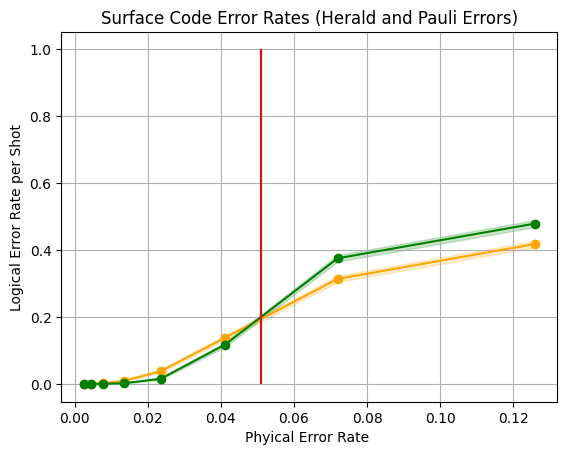

In [70]:
e_stats = sinter.stats_from_csv_files("combined_more_shots_erasure.csv")
p_stats = sinter.stats_from_csv_files("combined_more_shots_pauli.csv")

fig, ax = plt.subplots(1, 1)
plot_new_error(e_stats, p_stats, ax)

plt.vlines(5.1e-2, 1e-9, 1, "red")

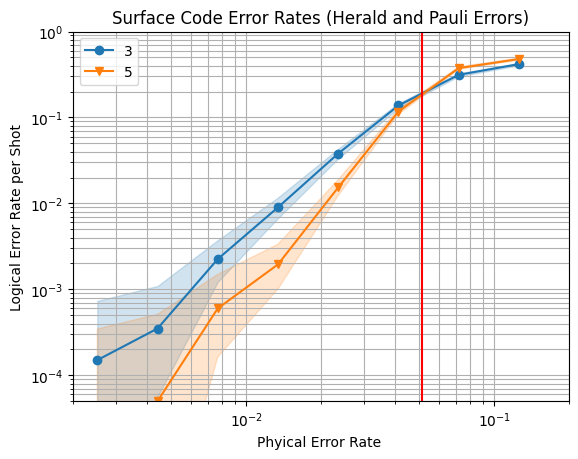

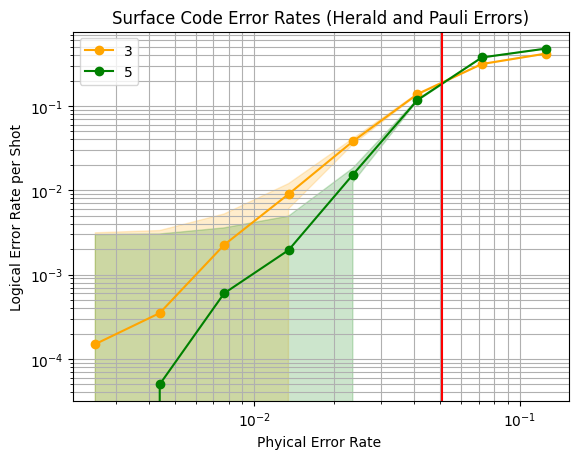

In [22]:
e_and_p_stats_more_shots = sinter.stats_from_csv_files('e_and_p_more_shots.csv')


# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_and_p_stats_more_shots,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d']
)

plt.xlim(2e-3,2e-1)
plt.ylim(5e-5,1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
ax.set_xlabel("Phyical Error Rate ")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.vlines(5.1e-2, 1e-9, 1, "red")
ax.legend()

fig, ax = plt.subplots(1, 1)
plot_new_norm_error(e_and_p_stats_more_shots,ax, erasure_shots = 1e4, pauli_shots = 1e4)
plt.vlines(5.1e-2, 1e-9, 1, "red")

logical errors 0.0, 0.0002

[]
[6]
[]
[6]
[]
[6]
logical errors 0.0005, 0.0004

[1]
[18]
[1]
[0.0015]
[1]
[18]
[1]
[0.0018]
[0]
[18]
[0]
[0.0012]
lower_coordinates (0.6666666666666666, 0.0015000000000000013)
high_coordinates (18.0, 0.9984999999999999)
logical errors 0.0026, 0.001

[19]
[54]
[19]
[0.0015]
[19]
[54]
[19]
[0.0018]
[18]
[54]
[18]
[0.0012]
lower_coordinates (18.666666666666668, 0.0015000000000000013)
high_coordinates (54.0, 0.9984999999999999)
logical errors 0.0202, 0.0049

[205]
[298]
[205]
[0.0015]
[206]
[299]
[206]
[0.0018]
[204]
[297]
[204]
[0.0012]
lower_coordinates (205.0, 0.0015000000000000013)
high_coordinates (298.0, 0.9984999999999999)
logical errors 0.0984, 0.011

[1000]
[1188]
[1000]
[0.0015]
[1002]
[1190]
[1002]
[0.0018]
[998]
[1186]
[998]
[0.0012]
lower_coordinates (1000.0, 0.0015000000000000013)
high_coordinates (1188.0, 0.9984999999999999)
logical errors 0.3152, 0.0318

[3322]
[3617]
[3322]
[0.0015]
[3325]
[3620]
[3325]
[0.0018]
[3319]
[3614]
[3319]
[0.0012]

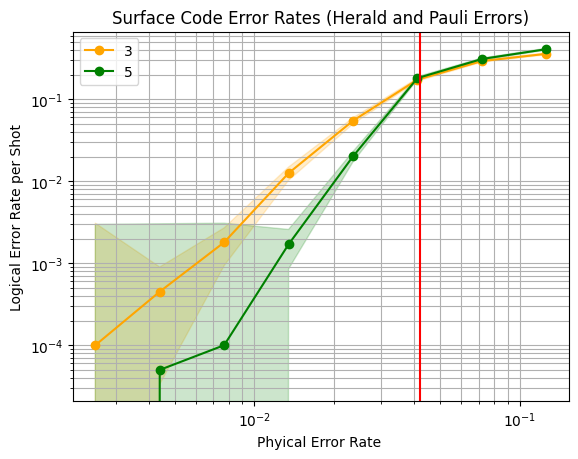

In [122]:
e_stats = sinter.stats_from_csv_files("combined_higher_e_fraction_erasure.csv")
p_stats = sinter.stats_from_csv_files("combined_higher_e_fraction_pauli.csv")

plot_new_error(e_stats, p_stats)

plt.vlines(4.2e-2, 1e-9, 1, "red")

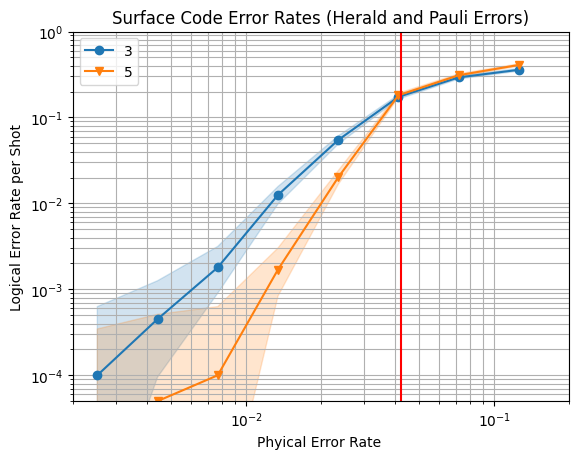

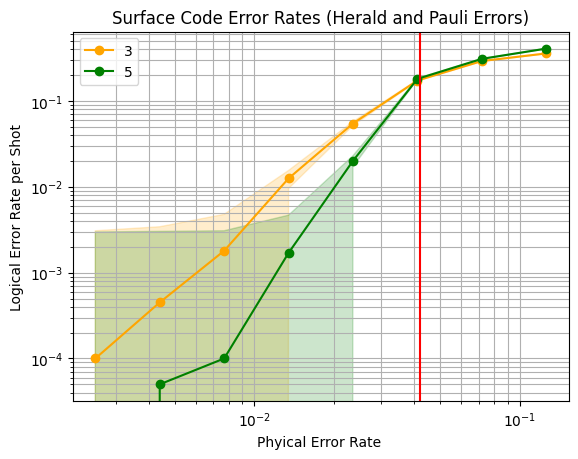

In [23]:
e_and_p_stats_more_shots = sinter.stats_from_csv_files('e_and_p_higher_e_fraction.csv')


# Render a matplotlib plot of the data.
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=e_and_p_stats_more_shots,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d']
)

plt.xlim(2e-3,2e-1)
plt.ylim(5e-5,1)
ax.loglog()
ax.set_title("Surface Code Error Rates (Herald and Pauli Errors)")
ax.set_xlabel("Phyical Error Rate ")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.vlines(4.2e-2, 1e-9, 1, "red")
ax.legend()

fig, ax = plt.subplots(1, 1)
plot_new_norm_error(e_and_p_stats_more_shots, ax, erasure_shots = 1e4, pauli_shots = 1e4)
plt.vlines(4.2e-2, 1e-9, 1, "red")

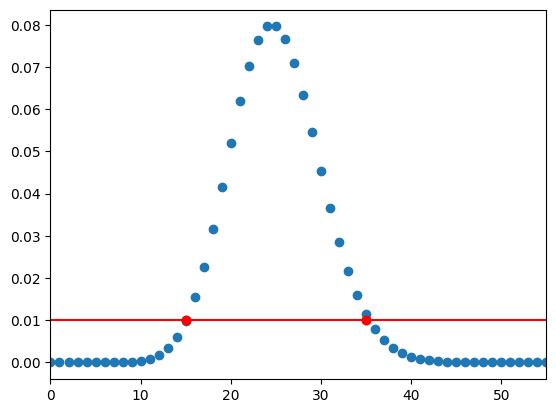

[0.0015 0.0035]
[0.0015 0.0035]


In [53]:
poi_in = list(np.linspace(1e-3,1e-3, 10**4)) + list(np.linspace(1.5e-3,1.5e-3, 10**4))
pmf = PoiBin(poi_in).pmf
plt.plot(pmf, "o")

plt.axhline(y=0.01, color='r', linestyle='-')
y_range = np.linspace(0.01, 0.01, 2*10**4)
y_range_2 = np.linspace(0.011, 0.011, 2*10**4)
x_range = np.arange(0, 10**4)

idx = np.argwhere(np.diff(np.sign(y_range - pmf[:-1]))).flatten()
idx_2 = np.argwhere(np.diff(np.sign(y_range_2 - pmf[:-1]))).flatten()
plt.plot(x_range[idx], y_range[idx], 'ro')
plt.plot(x_range[idx_2], y_range[idx_2], 'ro')

plt.xlim(0,idx[-1] + 20)
plt.show()

print(idx/10**4)
print(idx_2/10**4)

# idx = np.argwhere(np.diff(np.sign(f - pmf))).flatten()
# plt.plot(pmf[idx], 'ro')
# plt.show()

# all six plot

lower_coordinates (0.0, 0.0015000000000000013)
high_coordinates (15.0, 0.9984999999999999)
lower_coordinates (25.333333333333332, 0.0015000000000000013)
high_coordinates (65.33333333333333, 0.9984999999999999)
lower_coordinates (140.66666666666666, 0.0015000000000000013)
high_coordinates (220.0, 0.9984999999999999)
lower_coordinates (681.0, 0.0015000000000000013)
high_coordinates (841.3333333333334, 0.9984999999999999)
lower_coordinates (2614.0, 0.0015000000000000013)
high_coordinates (2898.0, 0.9984999999999999)
lower_coordinates (6084.0, 0.0015000000000000013)
high_coordinates (6454.666666666667, 0.9984999999999999)
lower_coordinates (8145.0, 0.0015000000000000013)
high_coordinates (8553.333333333334, 0.9984999999999999)
lower_coordinates (2.0, 0.0015000000000000013)
high_coordinates (22.333333333333332, 0.9984999999999999)
lower_coordinates (21.0, 0.0015000000000000013)
high_coordinates (57.666666666666664, 0.9984999999999999)
lower_coordinates (256.0, 0.0015000000000000013)
high_co

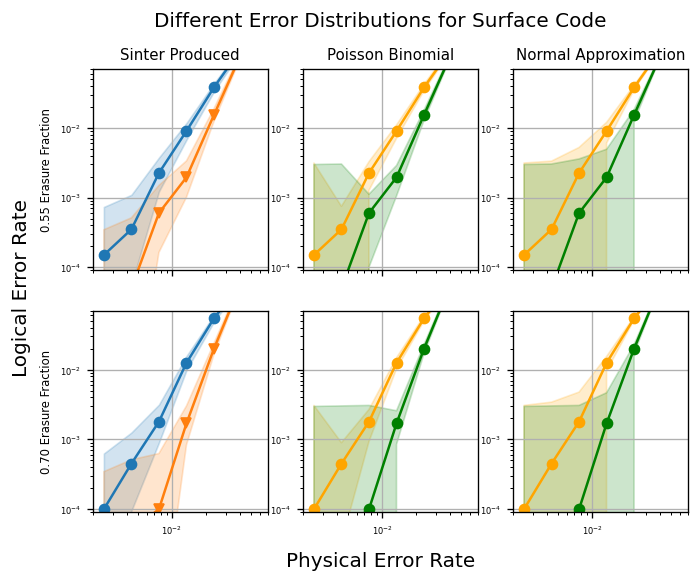

In [111]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex = True)


e_and_p_stats_more_shots = sinter.stats_from_csv_files('e_and_p_more_shots.csv')
e_and_p_stats_higher_e_frac = sinter.stats_from_csv_files('e_and_p_higher_e_fraction.csv')

e_stats_70 = sinter.stats_from_csv_files("combined_higher_e_fraction_erasure.csv")
p_stats_70 = sinter.stats_from_csv_files("combined_higher_e_fraction_pauli.csv")

e_stats_55 = sinter.stats_from_csv_files("combined_more_shots_erasure.csv")
p_stats_55 = sinter.stats_from_csv_files("combined_more_shots_pauli.csv")


plt.rc('font', size=10) #controls default text size
plt.rc("axes", titlesize=9)
plt.rc("axes", labelsize = 8)
plt.rc('xtick', labelsize=5) #fontsize of the x tick labels
plt.rc('ytick', labelsize=5) #fontsize of the y tick labels
plt.rc('legend', fontsize=8)

## 0.55

sinter.plot_error_rate(
    ax=ax1,
    stats=e_and_p_stats_more_shots,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d']
)
ax1.loglog()
ax1.set_title("Sinter Produced")
ax1.set_ylabel("0.55 Erasure Fraction")
ax1.set_xlim(2e-3, 7e-2)
ax1.set_ylim(9e-5, 7e-2)
ax1.grid(which='major')

plot_new_error(e_stats_55, p_stats_55, ax= ax2, show_title = False)
ax2.set_title("Poisson Binomial")
ax2.loglog()
ax2.set_xlim(2e-3, 7e-2)
ax2.set_ylim(9e-5, 7e-2)


plot_new_norm_error(e_and_p_stats_more_shots, ax =ax3, show_title = False)
ax3.set_title("Normal Approximation")
ax3.loglog()
ax3.set_xlim(2e-3, 7e-2)
ax3.set_ylim(9e-5, 7e-2)

# 0.7 

sinter.plot_error_rate(
    ax=ax4,
    stats=e_and_p_stats_higher_e_frac,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d']
)
ax4.loglog()
ax4.set_ylabel("0.70 Erasure Fraction")
ax4.set_xlim(2e-3, 7e-2)
ax4.set_ylim(9e-5, 7e-2)
ax4.grid(which='major')

plot_new_error(e_stats_70, p_stats_70, ax5, show_title = False)
ax5.loglog()
ax5.set_xlim(2e-3, 7e-2)
ax5.set_ylim(9e-5, 7e-2)

plot_new_norm_error(e_and_p_stats_higher_e_frac, ax6, show_title = False)
ax6.loglog()
ax6.set_xlim(2e-3, 7e-2)
ax6.set_ylim(9e-5, 7e-2)

fig.suptitle("Different Error Distributions for Surface Code")
fig.supxlabel("Physical Error Rate")
fig.supylabel("Logical Error Rate")
fig.set_dpi(120) 


lower_coordinates (0.0, 0.0015000000000000013)
high_coordinates (15.0, 0.9984999999999999)
lower_coordinates (25.333333333333332, 0.0015000000000000013)
high_coordinates (65.33333333333333, 0.9984999999999999)
lower_coordinates (140.66666666666666, 0.0015000000000000013)
high_coordinates (220.0, 0.9984999999999999)
lower_coordinates (681.0, 0.0015000000000000013)
high_coordinates (841.3333333333334, 0.9984999999999999)
lower_coordinates (2614.0, 0.0015000000000000013)
high_coordinates (2898.0, 0.9984999999999999)
lower_coordinates (6084.0, 0.0015000000000000013)
high_coordinates (6454.666666666667, 0.9984999999999999)
lower_coordinates (8145.0, 0.0015000000000000013)
high_coordinates (8553.333333333334, 0.9984999999999999)
lower_coordinates (2.0, 0.0015000000000000013)
high_coordinates (22.333333333333332, 0.9984999999999999)
lower_coordinates (21.0, 0.0015000000000000013)
high_coordinates (57.666666666666664, 0.9984999999999999)
lower_coordinates (256.0, 0.0015000000000000013)
high_co

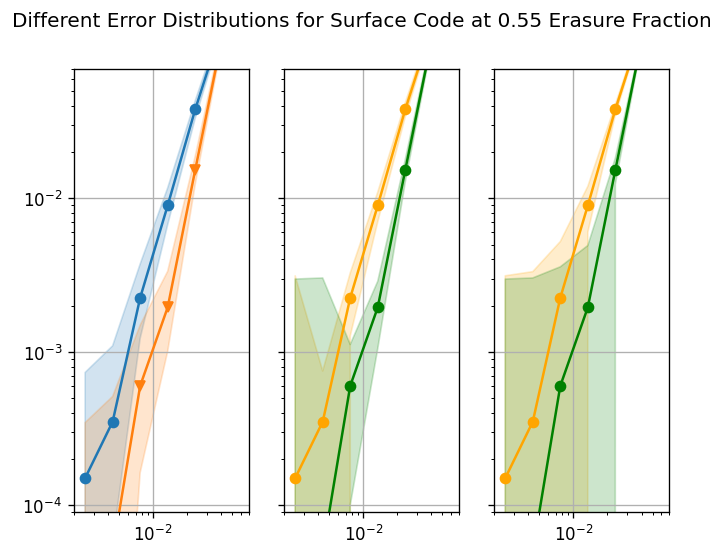

In [95]:
fig, ((ax1), (ax2), (ax3)) = plt.subplots(1, 3, sharey = True)

e_and_p_stats_more_shots = sinter.stats_from_csv_files('e_and_p_more_shots.csv')
e_and_p_stats_higher_e_frac = sinter.stats_from_csv_files('e_and_p_higher_e_fraction.csv')

e_stats_55 = sinter.stats_from_csv_files("combined_more_shots_erasure.csv")
p_stats_55 = sinter.stats_from_csv_files("combined_more_shots_pauli.csv")

sinter.plot_error_rate(
    ax=ax1,
    stats=e_and_p_stats_more_shots,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d']
)
ax1.loglog()
ax1.set_xlim(2e-3, 7e-2)
ax1.set_ylim(9e-5, 7e-2)
ax1.grid(which='major')

plot_new_error(e_stats_55, p_stats_55, ax = ax2, show_title = False)
ax2.loglog()
ax2.set_xlim(2e-3, 7e-2)

plot_new_norm_error(e_and_p_stats_more_shots, ax = ax3, show_title = False)
ax3.loglog()
ax3.set_xlim(2e-3, 7e-2)

fig.set_dpi(120) 
fig.suptitle("Different Error Distributions for Surface Code at 0.55 Erasure Fraction")
plt.show()